In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [63]:
from sklearn.metrics import accuracy_score , r2_score, mean_absolute_error ,f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split , cross_val_score , GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder ,OrdinalEncoder ,OneHotEncoder , StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt

# 📥 Data Loading

In [64]:
df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
print(df.shape)
print(df.info())

(18524, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB
None


# 📄Data Set Info

In [65]:
#check for null or unique values
print(df.columns)
print(df.nunique())

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')
id                           18524
Time_spent_Alone                12
Stage_fear                       2
Social_event_attendance         11
Going_outside                    8
Drained_after_socializing        2
Friends_circle_size             16
Post_frequency                  11
Personality                      2
dtype: int64


In [66]:
df.describe()



,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


# 🚧 Missing Values

NULL values
id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64


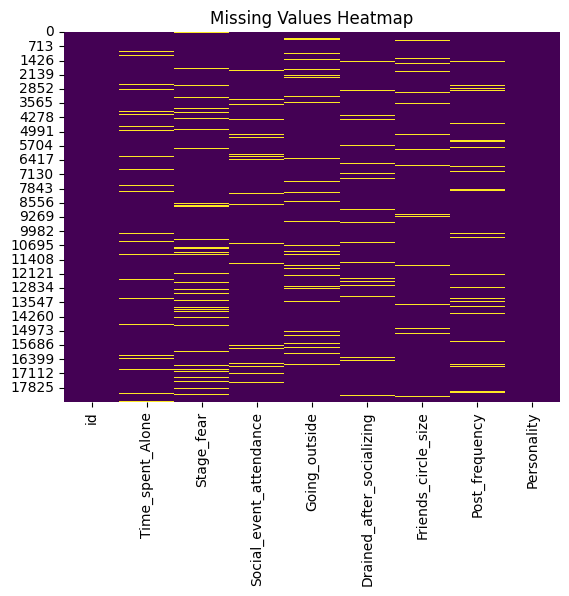

In [67]:
print("NULL values")
print(df.isnull().sum())
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

To handle missing values, the following strategies were applied:
- For numerical features, missing values were imputed using the most frequent value (mode), as it gave better accuracy during testing.

- For categorical features, missing values were replaced with the mode (most frequent category).

# 🔄 Splitting the Data

In [68]:
cat_features = df.select_dtypes(include=['object']).drop(['Personality'],axis=1).columns.tolist()
num_features = df.select_dtypes(exclude=['object']).drop(['id'],axis=1).columns.tolist()
X = df[num_features + cat_features]
y = df.Personality

X_train,X_valid , y_train, y_valid = train_test_split(X,y , test_size=0.2 , random_state=1)

# 🧼 Data Preprocessing

## 🔧Impute Missing Values

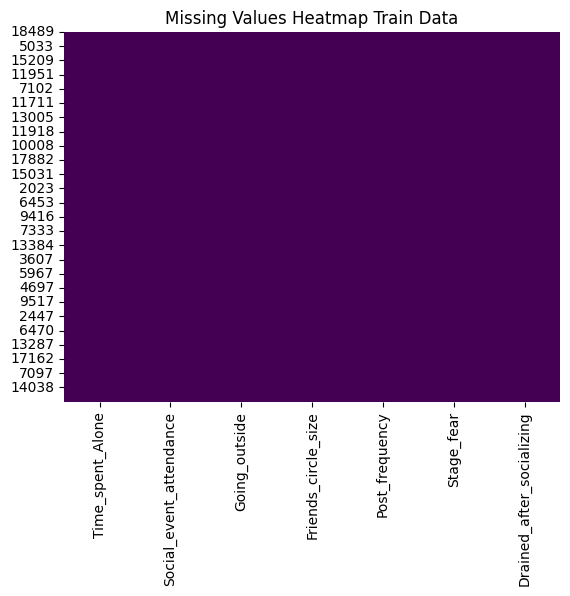

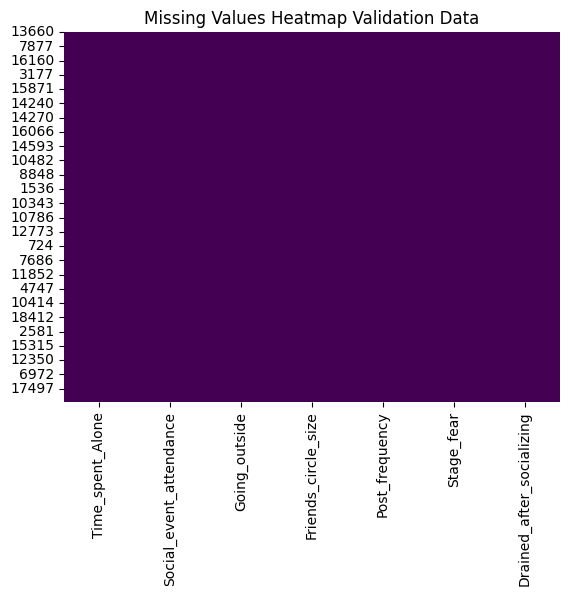

In [69]:
num_imputer = SimpleImputer(strategy='most_frequent')
cat_imputer = SimpleImputer(strategy='most_frequent')

#Imputing numerical values
X_train[num_features] = num_imputer.fit_transform(X_train[num_features])
X_valid[num_features] = num_imputer.transform(X_valid[num_features])


#Imputing categorical values
X_train[cat_features] = cat_imputer.fit_transform(X_train[cat_features])
X_valid[cat_features] = cat_imputer.transform(X_valid[cat_features])

sns.heatmap(X_train.isnull(),cbar=False,cmap='viridis')
plt.title("Missing Values Heatmap Train Data")
plt.show()
sns.heatmap(X_valid.isnull(),cbar=False,cmap='viridis')
plt.title("Missing Values Heatmap Validation Data")
plt.show()

## 🔡Encoding Categorical Values

In [70]:

#OneHotEncoding
X_train = pd.get_dummies(X_train, columns = cat_features)
X_valid = pd.get_dummies(X_valid, columns = cat_features)

X_train ,X_valid = X_train.align(X_valid, join='left', axis=1, fill_value=0)

#LabelEncoding()
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)



# 🤖 Model Training & Evaluation

## 🚀XGBoost

In [71]:
#XGBClassifier
xgb_model = XGBClassifier(
    max_depth=4,         
    learning_rate=0.01,   
    n_estimators=1000,    
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)
xgb_model.fit(X_train,y_train)
xgb_pred = xgb_model.predict(X_valid)
xgb_score = accuracy_score(y_valid,xgb_pred)
xgbf1_score = f1_score(y_valid,xgb_pred)
print(f"XGB : ACC: {xgb_score} F1: {xgbf1_score}")

XGB : ACC: 0.9668016194331984 F1: 0.9349550502379693


## 🌳Random Forest

In [72]:
#RandomForestClassifier
forest_model = RandomForestClassifier(n_estimators = 500,
                                     max_depth = 10,
                                     min_samples_split = 2,
                                     min_samples_leaf = 3,
                                     random_state=42)
forest_model.fit(X_train,y_train)
forest_pred = forest_model.predict(X_valid)
forest_score = accuracy_score(y_valid,forest_pred)
forestf1_score = f1_score(y_valid,forest_pred)
print(f"RF : ACC: {forest_score} F1: {forestf1_score}")

RF : ACC: 0.965991902834008 F1: 0.9333333333333332


## 🐱CATBoost

In [73]:
#catboost
cat_model = CatBoostClassifier(
    iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        verbose=0,
        early_stopping_rounds=50)
cat_model.fit(X_train,y_train)
cat_pred = cat_model.predict(X_valid)
cat_score = accuracy_score(y_valid,cat_pred)
catf1_score = f1_score(y_valid,cat_pred)
print(f"Cat : ACC: {cat_score} F1: {catf1_score}")

Cat : ACC: 0.9638326585695006 F1: 0.9292502639915523


## 🧮SVM

In [74]:
#SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

svm = SVC(kernel='rbf', C=1.0, gamma='scale')  # Try linear, poly, or rbf
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_valid_scaled)
svm_acc = accuracy_score(y_valid, svm_pred)
svm_f1 = f1_score(y_valid, svm_pred, average='weighted')
print(f"SVM: ACC: {svm_acc} F1: {svm_f1}")

SVM: ACC: 0.9665317139001349 F1: 0.9665550457943775


# 🧠 Final Model Training (Full Dataset)

In [75]:
# preprocess full data  to fit model with whole data
X_full_data = df[num_features + cat_features].copy()
y_full_data = df.Personality.copy()
X_full_data[num_features] = num_imputer.transform(X_full_data[num_features])
X_full_data[cat_features] = cat_imputer.transform(X_full_data[cat_features])
X_full_data= pd.get_dummies(X_full_data,columns = cat_features)
y_full_data= le.transform(y_full_data)

#Fit and transform full training data
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full_data)

finale_model = xgb_model
#finale_model.fit(X_full_scaled, y_full_data)  # ✅ use scaled data here when using svm
finale_model.fit(X_full_data,y_full_data)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# 📤 Test Data Preparation & Submission

In [76]:


# Prepare test data
X_test = test_data[num_features + cat_features].copy()
X_test[num_features] = num_imputer.transform(X_test[num_features])
X_test[cat_features] = cat_imputer.transform(X_test[cat_features])
X_test = pd.get_dummies(X_test, columns=cat_features)
X_test = X_test.reindex(columns=X_full_data.columns, fill_value=0)

# Scale test data using the same scaler
#X_test_scaled = scaler.transform(X_test)

# Predict and inverse transform
#test_preds = finale_model.predict(X_test_scaled)
test_preds = finale_model.predict(X_test)
test_preds = le.inverse_transform(test_preds)

# Submission
submission = pd.DataFrame({
    'id': test_data['id'],
    'Personality': test_preds
})
submission.to_csv('submission.csv', index=False)
